正在加载样本...
🎉 Gamma 对比 Corner 图已输出: corner_gamma_comparison.pdf


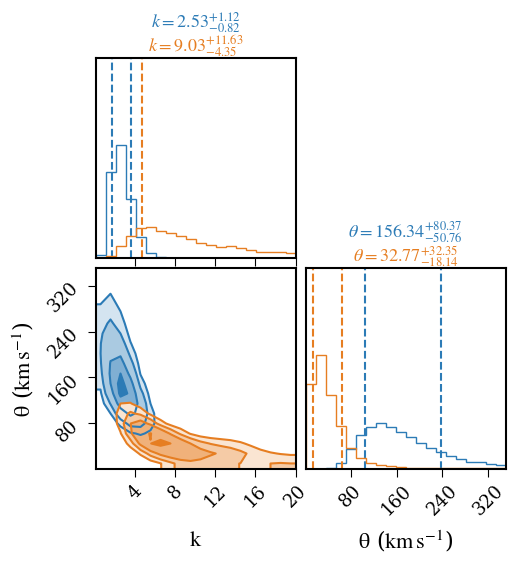

In [1]:
import pickle
import numpy as np
import corner
import matplotlib.pyplot as plt
from dynesty import utils

# ================= 1. 文件路径 =================
# Blue (Dataset 1)
path_gamma1 = "/home/lz/work/pulsar_kick_velocity/hy_outdir/u_hype_68279_dynesty.pickle"
# Orange (Dataset 2)
path_gamma2 = "/home/lz/work/pulsar_kick_velocity/hy_outdir/u_hype_45593_dynesty.pickle"# ================= 2. Plotting Style (ApJ) =================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})

# ================= 3. 数据加载函数 =================
def load_samples(path):
    """从 dynesty pickle 文件中加载并重采样等权重的样本"""
    try:
        with open(path, "rb") as f:
            results = pickle.load(f)
    except FileNotFoundError:
        print(f"错误：文件未找到 at {path}")
        return np.array([[np.nan, np.nan]])

    # 重新采样获取等权重样本
    weights = np.exp(results.logwt - results.logz[-1])
    return utils.resample_equal(results.samples, weights)

# 加载样本
print("正在加载样本...")
samples_g1 = load_samples(path_gamma1) # Blue
samples_g2 = load_samples(path_gamma2) # Orange

# 检查维度
if samples_g1.shape[1] != 2 or samples_g2.shape[1] != 2:
    print("警告：样本维度不是预期的 2 (k, theta)。绘图可能出错。")

# ================= 4. 绘图参数配置 =================

# 颜色定义
color_1 = "#2C7BB6"   # Blue (path_gamma1 / 68279)
color_2 = "#E67E22"   # Orange (path_gamma2 / 45597)

# 标签定义 (LaTeX)
# Labels for axis titles
labels = [r"$\mathrm{k}$", r"$\mathrm{\theta}$ ($\mathrm{km}\,\mathrm{s}^{-1}$)"]
# Names for the text annotation (k, theta)
param_names = [r"k", r"\theta"]

# 绘图范围 (Ranges)
# 注意：根据您的数据分布，这里使用了您提供的范围。如果截断了，请适当放宽。
ranges = [(0.1, 20), (1, 350.0)] 
n_params = len(labels)

# ================= 5. 绘制 Corner 图 =================

# --- 第一层：蓝色 (Dataset 1) ---
fig = corner.corner(
    samples_g1,
    labels=labels,
    color=color_1,
    fill_contours=True,      # 填充颜色
    plot_datapoints=False,   # 不画散点，保持整洁
    show_titles=False,       # 我们手动添加标题
    smooth=1.0,
    range=ranges,
    quantiles=[0.16, 0.84],
    hist_kwargs={"density": True, "color": color_1}
)

# --- 第二层：橙色 (Dataset 2) - 叠加 ---
corner.corner(
    samples_g2,
    fig=fig,                 # 关键：传入 fig 进行叠加
    color=color_2,
    fill_contours=True,
    plot_datapoints=False,
    show_titles=False,
    smooth=1.0,
    range=ranges,
    quantiles=[0.16, 0.84],
    hist_kwargs={"density": True, "color": color_2}
)

# ================= 6. 添加统计数据文本 =================

def median_err(samples):
    """计算中位数和 16th/84th 百分位误差"""
    q16, q50, q84 = np.percentile(samples, [16, 50, 84])
    return q50, q50 - q16, q84 - q50

n_bins = 40 # 用于计算直方图高度的 bin 数量
axes = np.array(fig.axes).reshape(n_params, n_params)

for i in range(n_params):
    ax = axes[i, i]
    
    # --- 动态调整 Y 轴高度 ---
    # 为了防止文字遮挡直方图，我们需要计算两个分布的最大高度，并留出空间
    bins = np.linspace(ranges[i][0], ranges[i][1], n_bins + 1)
    
    counts_1, _ = np.histogram(samples_g1[:, i], bins=bins, density=True)
    counts_2, _ = np.histogram(samples_g2[:, i], bins=bins, density=True)
    
    # 找出最高的峰值
    ymax_counts = max(counts_1.max() if counts_1.size else 0,
                      counts_2.max() if counts_2.size else 0)

    # 设置 Y 轴上限 (峰值的 1.6 倍，留足空间写两行字)
    if ymax_counts > 0:
        new_top = ymax_counts * 1.6 
        cur_ymin, cur_ymax = ax.get_ylim()
        if new_top > cur_ymax:
             ax.set_ylim(0, new_top) 

    # --- 准备文本 ---
    # Blue Text (Dataset 1)
    m1, lo1, hi1 = median_err(samples_g1[:, i])
    text_1 = fr"${param_names[i]} = {m1:.2f}^{{+{hi1:.2f}}}_{{-{lo1:.2f}}}$"
    
    # Orange Text (Dataset 2)
    m2, lo2, hi2 = median_err(samples_g2[:, i])
    text_2 = fr"${param_names[i]} = {m2:.2f}^{{+{hi2:.2f}}}_{{-{lo2:.2f}}}$"
    
    # --- 写入文本 ---
    # 蓝色写在最上面 (y=1.1, 相对坐标)
    ax.text(
        0.5, 1.12, text_1,
        color=color_1, fontsize=13,
        ha="center", va="bottom",
        transform=ax.transAxes
    )
    
    # 橙色写在蓝色下面 (y=1.0, 相对坐标)
    ax.text(
        0.5, 1.0, text_2,
        color=color_2, fontsize=13,
        ha="center", va="bottom",
        transform=ax.transAxes
    )

# ================= 7. 保存图片 =================
output_filename = "corner_gamma_comparison.pdf"
fig.savefig(output_filename, dpi=300, bbox_inches="tight")
print(f"🎉 Gamma 对比 Corner 图已输出: {output_filename}")